## Shallow neural network models

We revise here the classification exercises on the `iris` dataset moving from logistic regression to shallow neural networks.
Initially, we'll address binary classification.

We first import some libraries and the dataset:

In [ ]:
## import libraries
import numpy as np
import tensorflow as tf
import pandas as pd
import sklearn.datasets
import matplotlib.pyplot as plt


In [ ]:
## setting seeds
from numpy.random import seed
seed(777)

import tensorflow as tf
tf.random.set_seed(777)

In [ ]:
iris = sklearn.datasets.load_iris()
iris.data = pd.DataFrame(iris.data, columns=iris.feature_names) #converting numpy array -> pandas DataFrame
iris.target = pd.Series(iris.target) #converting numpy array -> pandas Series
iris.target = iris.target.to_frame() #converting Pandas series to dataframe
print('Shape of the feature table: ' + str(iris.data.shape))
print('Shape of the target array: ' + str(iris.target.shape))

Shape of the feature table: (150, 4)
Shape of the target array: (150, 1)


We are now using all four features of the `iris` dataset: `sepal length (cm)`, `sepal width (cm)`, `petal length (cm)` and `petal width (cm)`. As before, we first reduce the problem to binary classification, by merging two classes together

In [ ]:
features = iris.data.iloc[:,:]
target = iris.target

#updating class labels. To makes things difficult we put together old classes 0 and 1
#in a new class (non virginica) and keep old class 2 (virginica) as new class 1.
#For an easier problems put together versicolor and virginica and keep setosa by itself
n1 = 100 ## split: 50 for setosa vs versicolor+virginica, 100 for setos+versicolor vs virginica
target[0:n1] = 0
target[n1:150] = 1

print(iris.target.iloc[:,0].value_counts())

0    100
1     50
Name: 0, dtype: int64


As before, a visual check of the two classes:

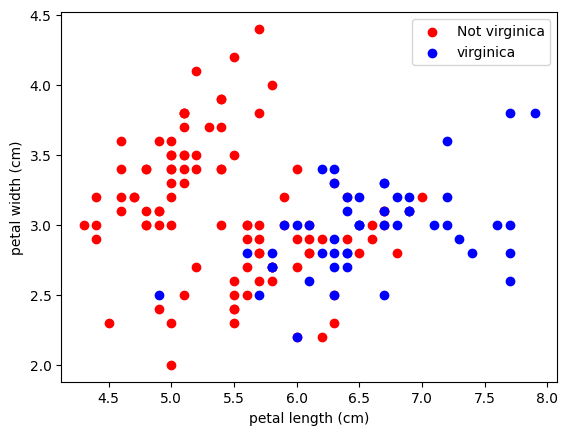

In [ ]:
feature_x = 2
feature_y = 3

#starting a new plot
fig, ax = plt.subplots()

#adding data in two bunches
ax.scatter(x=features.iloc[0:n1,0],   y=features.iloc[0:n1,1],   c='red',  label='Not virginica')
ax.scatter(x=features.iloc[n1:150,0], y=features.iloc[n1:150,1], c='blue', label='virginica')

#the axis names are taken from feature names
ax.set_xlabel(iris.feature_names[feature_x])
ax.set_ylabel(iris.feature_names[feature_y])

#adding the legend and printing the plot
ax.legend()
plt.show()

### Neural Network model

In the previous exercise we used logistic regression implemented as a simple neural network model with just the output layer: this output layer had only one node (binary classification) which performed both the regression (linear combination of input variables + bias) and sigmoid activation steps:

<img src="https://drive.google.com/uc?export=view&id=1PRc719uT1kOUuCMbpHML2sEk7qp6UJnm">

We are now building a **shallow neural network model**, by adding **one hidden layer** with **u nodes** (units):

<img src="https://drive.google.com/uc?export=view&id=1QROz9pFnMoqTeqrFbele8pFz8qXDSckq">

We now have to set a number of `hyperparameters` (the **building blocks** -or 'ingredients'- of a neural network model):

- the **number of hidden nodes** (number of units in the hidden layer)
- the **type of activation function** in the hidden layer
- the **output activation function**
- the **loss function** (for backpropagation)
- the **optimizer** (for gradient descent)

In [ ]:
## # Configuration options
input_shape = (features.shape[1],) ## tuple that specifies the number of features
hidden_nodes = 8
hidden_activation = 'relu'
output_activation = 'sigmoid'
loss_function = 'binary_crossentropy'
optimizer_used = 'SGD' ##stochastic gradient descent
num_epochs = 200

**Question for you: what is the size of the input matrix $\mathbf{X}$, the matrix of coefficients $\mathbf{W}$ and the vector of bias terms $\mathbf{b}$ in the hidden layer (layer n. 1)?**

We chose <a href='https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a'>binary cross-entropy</a> for binary classification problems: this is the loss function we have been discussing in the slides.
As for the optimizer, we use `rmsprop`: more details on the available otimizers in Keras can be found <a href='https://keras.io/api/optimizers/'>here</a>

In [ ]:
print(input_shape)

(4,)


**Question for you: what does the `input_shape` indicate?**

#### Training and test sets

We now prepare the training and test set for correct evaulation of the neural network model performance: we make one split (one training set and one test set), and assign 80% of the data to the training set and 20% of the data to the test set

In [ ]:
#we want to have the same proportion of classes in both train and validation sets
from sklearn.model_selection import StratifiedShuffleSplit

#building a StratifiedShuffleSplit object (sss among friends) with 20% data
#assigned to validation set (here called "test")
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

#the .split() method returns (an iterable over) two lists which can be
#used to index the samples that go into train and validation sets
for train_index, val_index in sss.split(features, target):
    features_train = features.iloc[train_index, :]
    features_val   = features.iloc[val_index, :]
    target_train   = target.iloc[train_index,:]
    target_val     = target.iloc[val_index,:]

#let's print some shapes to get an idea of the resulting data structure
print("Training features size: ", features_train.shape)
print("Test features size: ", features_val.shape)
print("Training targets size: ", target_train.shape)
print("Test targets size: ", target_val.shape)

print("Type of the training features object: ", type(features_train))
print("Type of the training targets object: ", type(target_train))

Training features size:  (120, 4)
Test features size:  (30, 4)
Training targets size:  (120, 1)
Test targets size:  (30, 1)
Type of the training features object:  <class 'pandas.core.frame.DataFrame'>
Type of the training targets object:  <class 'pandas.core.frame.DataFrame'>


#### Building the neural network model

We now build the (shallow) **neural network model** using the `Keras` framework: we choose a `sequential` architecture and add `dense` (fully connected) layers (**1 hidden layer**, **1 output layer**).

We chose `ReLU` activation functions for the units in the hidden layer, and `sigmoid` activation function for the output layer.



In [ ]:
#we are building a "sequential" model, meaning that the data will
#flow like INPUT -> ELABORATION -> OUTPUT.
from keras.models import Sequential

#a "dense" layer is a layer were all the data coming in are connected
#to all nodes.
from keras.layers import Dense

# binary classification shallow neural network model in Keras
model = Sequential()
model.add(Dense(units=hidden_nodes, input_shape=input_shape, activation=hidden_activation))
model.add(Dense(1, activation=output_activation))

#the model is declared, but we still need to compile it to actually
#build all the data structures
model.compile(optimizer=optimizer_used, loss=loss_function)

In [ ]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 40        
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 49 (196.00 Byte)
Trainable params: 49 (196.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


The `summary()` method of the Keras model tells us that there are 49  parameters to train:
- w1, w2, w3, w4, b (weights for the 4 features + bias term) for each of the 8 nodes in the hidden layer ($\rightarrow$ 40 parameters);
- w1 - w8 + b (weights for the 8 nodes results + bias term) for the output layer ($\rightarrow$ 9 parameters) [&#161; you may remember from the matrix dimensions we discussed in the slides !]

#### Training the neural network model

We have now prepared everything we need and are ready to train the model on our data. It's an iterative process that cycles many times through what are called `epochs` (~ iterations). We'll start with using the parameter set above:


In [ ]:
history = model.fit(features_train, target_train, epochs=num_epochs, validation_data=(features_val, target_val), verbose=0)

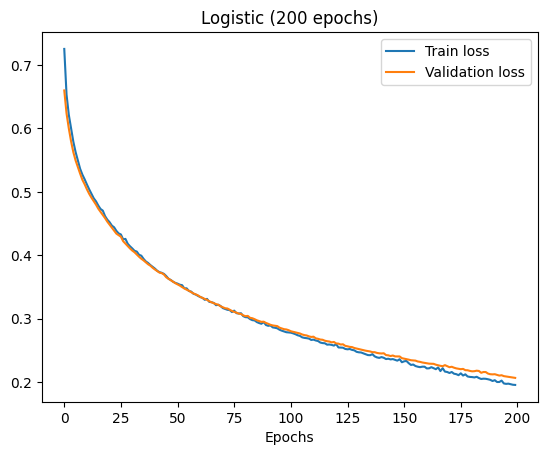

In [ ]:
def plot_loss_history(h, title):
    plt.plot(h.history['loss'], label = "Train loss")
    plt.plot(h.history['val_loss'], label = "Validation loss")
    plt.xlabel('Epochs')
    plt.title(title)
    plt.legend()
    plt.show()

plot_loss_history(history, 'Logistic ({} epochs)'.format(num_epochs))

#### Confusion matrix

With more than two features we can't plot the decision boundary; however, we can have an idea of the performance of our classification model by looking at the <a href="https://en.wikipedia.org/wiki/Confusion_matrix">confusion matrix</a>:

In [ ]:
from sklearn.metrics import confusion_matrix
predictions = model.predict(features_val)
predicted_labels = np.where(predictions > 0.5, "virginica", "non-virginica")
target_labels = target_val.to_numpy().reshape((len(target_val),1))
target_labels = np.where(target_labels > 0.5, "virginica", "non-virginica")

con_mat_df = confusion_matrix(target_labels, predicted_labels, labels=["non-virginica","virginica"])
print(con_mat_df)

1/1 [==============================] - 0s 286ms/step
[[18  2]
 [ 0 10]]


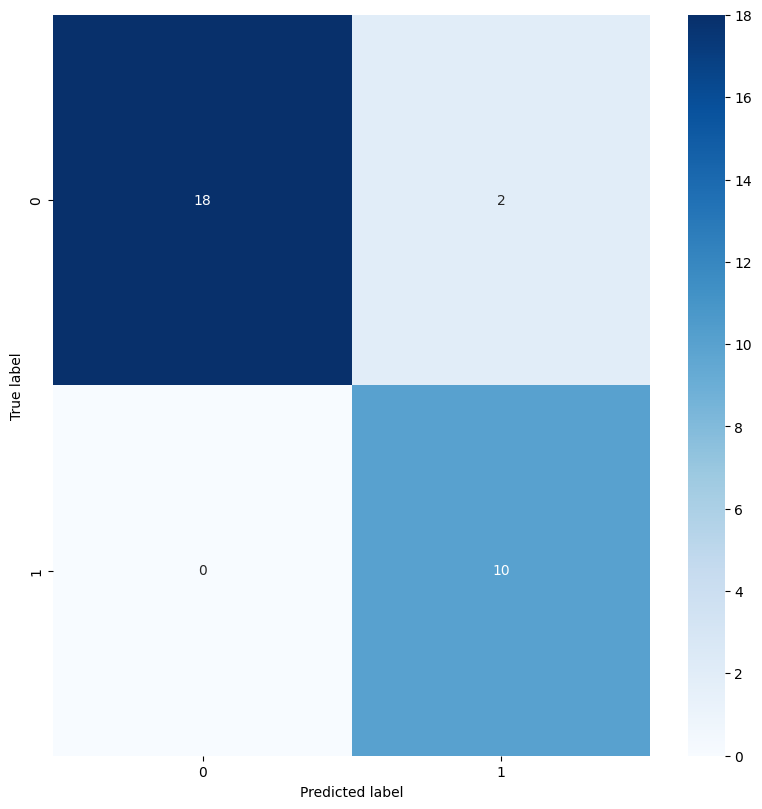

In [ ]:
import seaborn as sn

figure = plt.figure(figsize=(8, 8))
sn.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

We can now calculate the **overall accuracy** of the model, and the **TPR** (true positive rate) and the **TNR** (true negative rate):

$$
\text{TPR}=\frac{TP}{TP+FN}\\
$$

$$
\text{TNR}=\frac{TN}{TN+FP}\\
$$


In [ ]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(target_labels, predicted_labels)
tn, fp, fn, tp = con_mat_df.ravel()
tpr = tp/(tp+fn)
tnr = tn/(tn+fp)

print("Overall accuracy is: ", accuracy)
print("TPR is: ", tpr)
print("TNR is: ", tnr)

Overall accuracy is:  0.9333333333333333
TPR is:  1.0
TNR is:  0.9


- going deeper
- dl for logistic regression is a bit of an overkill (Ng's slide below)

## A deeper neural networks model



In [ ]:
input_shape = (features_train.shape[1],) ## tuple that specifies the number of features
hidden_nodes_1 = 8
hidden_nodes_2 = 5
hidden_activation_1 = 'relu'
hidden_activation_2 = 'tanh'
output_activation = 'sigmoid'
loss_function = 'binary_crossentropy'
optimizer_used = 'rmsprop' ## Root Mean Square Propagation
num_epochs = 200

In [ ]:
# binary classification shallow neural network model in Keras
model = Sequential()
model.add(Dense(units=hidden_nodes_1, input_shape=input_shape, activation=hidden_activation_1))
model.add(Dense(units=hidden_nodes_2, activation=hidden_activation_2))
model.add(Dense(1, activation=output_activation))

#the model is declared, but we still need to compile it to actually
#build all the data structures
model.compile(optimizer=optimizer_used, loss=loss_function)

In [ ]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 8)                 40        
                                                                 
 dense_3 (Dense)             (None, 5)                 45        
                                                                 
 dense_4 (Dense)             (None, 1)                 6         
                                                                 
Total params: 91 (364.00 Byte)
Trainable params: 91 (364.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
history = model.fit(features_train, target_train, epochs=num_epochs, validation_data=(features_val, target_val), verbose=0)

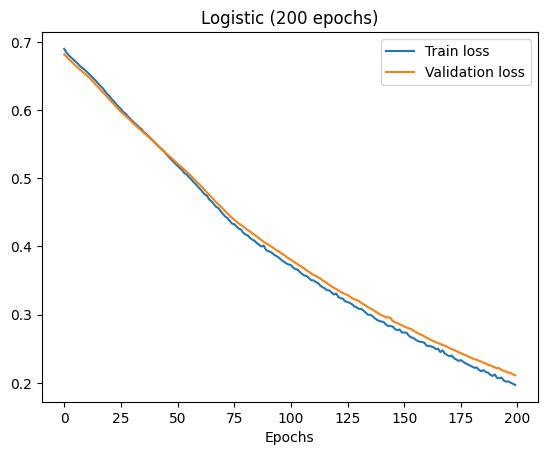

In [ ]:
plot_loss_history(history, 'Logistic ({} epochs)'.format(num_epochs))

In [ ]:
predictions = model.predict(features_val)
predicted_labels = np.where(predictions > 0.5, "virginica", "non-virginica")
target_labels = target_val.to_numpy().reshape((len(target_val),1))
target_labels = np.where(target_labels > 0.5, "virginica", "non-virginica")

con_mat_df = confusion_matrix(target_labels, predicted_labels, labels=["non-virginica","virginica"])
print(con_mat_df)

1/1 [==============================] - 0s 66ms/step
[[19  1]
 [ 0 10]]


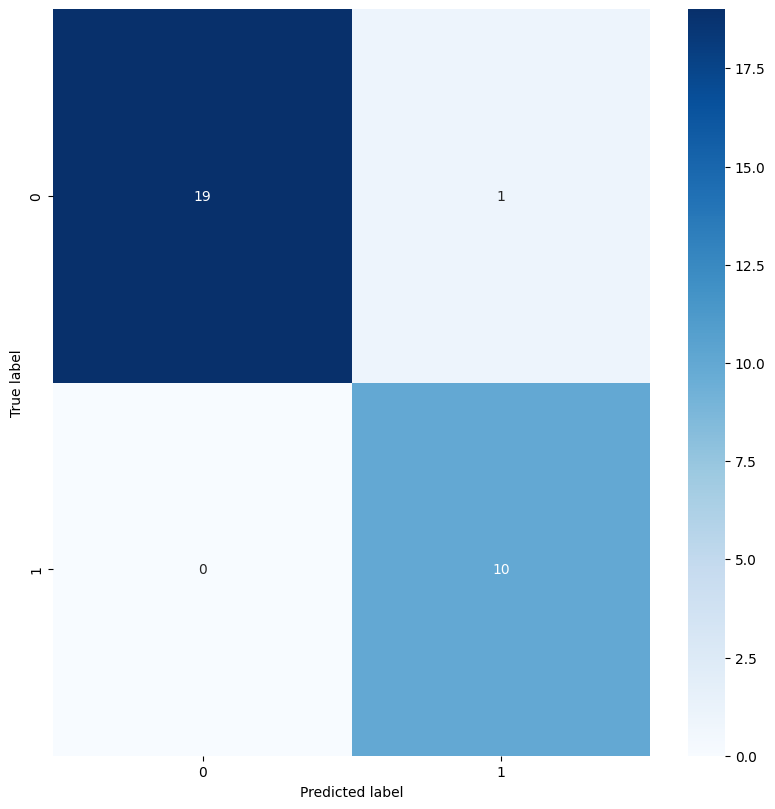

In [ ]:
figure = plt.figure(figsize=(8, 8))
sn.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
accuracy = accuracy_score(target_labels, predicted_labels)
tn, fp, fn, tp = con_mat_df.ravel()
tpr = tp/(tp+fn)
tnr = tn/(tn+fp)

print("Overall accuracy is: ", accuracy)
print("TPR is: ", tpr)
print("TNR is: ", tnr)

Overall accuracy is:  0.9666666666666667
TPR is:  1.0
TNR is:  0.95


## A side note

Neural networks models and deep learning models may be an overkill when applied to a classification problem on 150 samples and 4 features: it is not even guaranteed that they will perform better than simpler machine learning methods like logistic regression. Indeed at times deep learning may perform worse than simpler approaches.
As a matter of fact, deep learning is known to work best when the size of the problem is very large (both in terms of amount of data and order of computations needed), and the advent of *Big Data* is exactly one of the drivers behind the rise of deep learning.

The Figure below comes from slides by <a href='https://en.wikipedia.org/wiki/Andrew_Ng'>Andrew Ng</a> and illustrates this point: when the amount of data is limited, traditional machine learning methods and small and large neural networks have similar performance. It is only when the size of the problem increases that deep learning shows its potential and consistently outperforms other methods/algorithms.



<img src="https://drive.google.com/uc?export=view&id=1_Nom99R963AhM30UbbDLg4-u-mPSiX_L">

As a matter of fact, a reliable way to get better predictive performance is often to either **train a bigger network** or feed **more data** to it.
Eventually you'll hit the limit: i) run out of training examples; or ii) network so big that it is too slow to train